In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from utils.get_summary_data import compile_summary
from utils.paths import SetupPaths

In [2]:
plt.rcParams.update({'font.size':22})
paths = SetupPaths()


In [3]:
style = {"dark":"dashed","hydro":"solid"}
palette = { "dark":"#044751","hydro": "#B6DAFF", 
           "Illustris":"#668AFF","TNG": "#B6DAFF", # "TNG": "#7B55F3"
           "Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC",
           "All Pairs":"#668AFF","Major Pairs": "#7B55F3",
           "Minor Pairs":'#FFB201',"Minor Plus Pairs":"#FF6300",
           "Extra":"#DE2280","Stellar":"#0A68DD",
           "Halo":"#4B0094","Max Halo":"#FF6BB7"}
alphaVal = {"Major":0.7,"Minor":0.4}

In [12]:
savepath = f"TNG_99_10_matched.hdf5"
f = h5py.File(f"{paths.path_data}matched/Vicente/{savepath}", 'r')

In [13]:
f.keys()

<KeysViewHDF5 ['Header', 'paired', 'unpaired']>

In [16]:
f['paired']['hydro']['Separation']


<KeysViewHDF5 ['Comoving Separation', 'Group ID', 'Group Mass', 'Group Nsubs', 'Group Radius', 'Realization', 'RelVel', 'Separation', 'Stellar Mass Ratio', 'Sub1 BHMass', 'Sub1 BHMdot', 'Sub1 GasMetallicity', 'Sub1 ID', 'Sub1 Mass', 'Sub1 MassType', 'Sub1 Pos', 'Sub1 SFR', 'Sub1 SFRinRad', 'Sub1 Stellar Mass', 'Sub1 Vel', 'Sub2 BHMass', 'Sub2 BHMdot', 'Sub2 GasMetallicity', 'Sub2 ID', 'Sub2 Mass', 'Sub2 MassType', 'Sub2 Pos', 'Sub2 SFR', 'Sub2 SFRinRad', 'Sub2 Stellar Mass', 'Sub2 Vel', 'TripleFlag']>

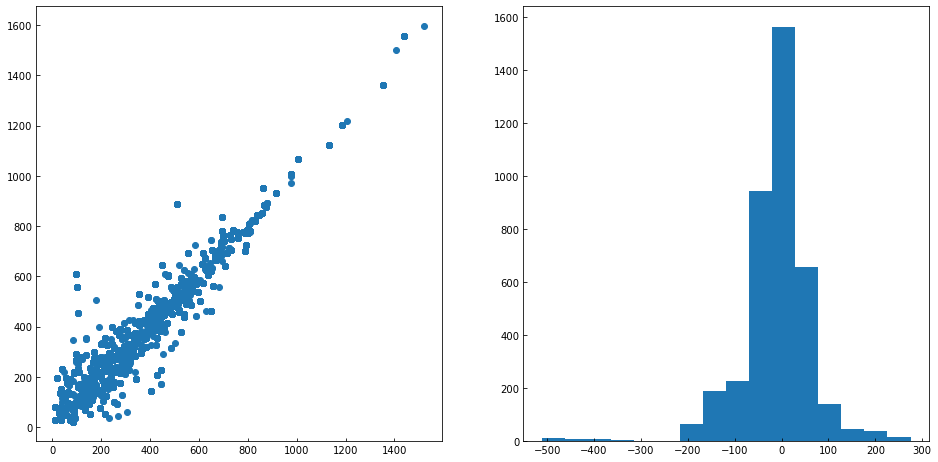

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=False)
plt.subplots_adjust(wspace=0.2)

ax[0].scatter(np.array(f['paired']['hydro']['Separation']), np.array(f['paired']['dark match']['Separation']))
ax[1].hist(np.array(f['paired']['hydro']['Separation'])-np.array(f['paired']['dark match']['Separation']))
# ax[1].scatter(np.array(illh["Separation"])[illhmask], np.array(illh["RelVel"])[illhmask])

# darkseps = sim['dark']['dwarf']["Separation"]
# darkvels = sim['dark']['dwarf']["RelVel"]

# hydroseps = sim['hydro']['dwarf']["Separation"]
# hydrovels = sim['hydro']['dwarf']["RelVel"]

# ax[0].scatter(darkseps, darkvels,label=simNames[ind],color=palette[simNames[ind]])
# ax[1].scatter(hydroseps, hydrovels,label=simNames[ind],color=palette[simNames[ind]])

# ax[0].scatter(darkseps[darkmask], darkvels[darkmask],color='black')
# ax[1].scatter(hydroseps[hydromask], hydrovels[hydromask],color='black')

# for i in ax:
#     i.set_xlim(0,800)e
#     i.set_xlabel("Separation [kpc]")
    
# ax[0].legend(loc="upper right")
# ax[0].set_ylabel("Relative velocity [km/s]")
# ax[0].set_xlabel("Separation [kpc]")
# ax[1].set_xlabel("Separation [kpc]")

plt.show()


In [10]:
snapshot = 99
sim = "TNG"
num_reals = 10

paths = SetupPaths()

## find subhalos for this simulation and snapshot #
pair_path = f"{sim}_{snapshot}_{num_reals}.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")

# savepath = f"{sim}_{snapshot}_{num_reals}_matched.hdf5"
# f = h5py.File(f"{paths.path_pairs}{savepath}", 'w')

redshift = pair_data["Header"].attrs["Redshift"]
scale = 1 / (1 + redshift)

units_dict = {
      ### Group info
    "Group ID":"Group Number in Subfind Catalogs", 
    "Group Mass":"Physical mass from Group_M_TopHat200 -- 1e10 Msun",
    "Group Radius":"Physical radius from Group_R_TopHat200 -- kpc",
    "Group Nsubs":"Number of subhalos in group",
      ### Subhalo info
    "Sub1 ID":  "Subhalo ID at current snapshot",
    "Sub2 ID":  "Subhalo ID at current snapshot",
    "Sub1 Mass": "Subhalo mass at current snapshot -- 1e10 Msun",
    "Sub2 Mass": "Subhalo mass at current snapshot -- 1e10 Msun",
    "Sub1 Stellar Mass": "Stellar masses from abundance matching -- 1e10 Msun",
    "Sub2 Stellar Mass": "Stellar masses from abundance matching -- 1e10 Msun",
    "Sub1 Pos": "Subhalo physical position in box x,y,z -- kpc",
    "Sub2 Pos": "Subhalo physical position in box x,y,z -- kpc",
    "Sub1 Vel": "Subhalo velocity in vx, vy, vz -- km/s",
    "Sub2 Vel": "Subhalo velocity in vx, vy, vz -- km/s",
    "Sub1 MassType": "Mass of bound particles - gas, DM, empty, tracers, stars, BHs -- in 1e10 Msun",
    "Sub2 MassType": "Mass of bound particles - gas, DM, empty, tracers, stars, BHs -- in 1e10 Msun",
    "Sub1 BHMass": "Sum of the masses of all blackholes -- 1e10 Msun",
    "Sub2 BHMass": "Sum of the masses of all blackholes -- 1e10 Msun",
    "Sub1 BHMdot": "Instantaneous accretion rates of all blackholes -- 1e10 Msun / 0.978Gyr",
    "Sub2 BHMdot": "Instantaneous accretion rates of all blackholes -- 1e10 Msun / 0.978Gyr",
    "Sub1 SFR": "Sum of the individual SFRs of all gas cells in subhalo -- Msun / yr",
    "Sub2 SFR": "Sum of the individual SFRs of all gas cells in subhalo -- Msun / yr",
    "Sub1 SFRinRad": "Sum of SFRs of all gas cells within twice the stellar half mass radius -- Msun / yr",
    "Sub2 SFRinRad": "Sum of SFRs of all gas cells within twice the stellar half mass radius -- Msun / yr",
    "Sub1 GasMetallicity": "Mz/Mtot, where Z = any element above He within 2x stellar half mass radius -- unitless",
    "Sub2 GasMetallicity": "Mz/Mtot, where Z = any element above He within 2x stellar half mass radius -- unitless",
      ### Relative vals
    "Separation": "Physical separation between primary and secondary in kpc",
    "Comoving Separation":"Comoving separation between primary and secondary in ckpc",
    "RelVel": "Relative velocity between primary and secondary in km/s",
    "Stellar Mass Ratio": "Stellar mass ratio of secondary over primary", # in this case- it's by primary subhalo mass
    "Realization": "Stellar mass realization (0-1000)",
    "TripleFlag": "0 if no tertiary with mass ratio > 1:10 of secondary, 1 if large tertiary, 2 if other problem occurred"
    }

# #create header with simulation info
# header_dict = {"Snapshot":snapshot,
#         "Redshift":redshift,
#         "Simulation":sim}

# dset = f.create_group('/Header')
# for key in header_dict.keys():
#     dset.attrs[key] = header_dict[key]

# f.close()

#########################
# open matched catalogs #
#########################

match_Npath = h5py.File(f"{paths.path_tngmatch_N}", "r")
matchedN = match_Npath[f'Snapshot_{snapshot}']
darkidsN = np.array(matchedN['SubhaloIndexDark_SubLink'])

matchedV = h5py.File(f"{paths.path_tngmatch_V}dm_match_{str(snapshot).zfill(3)}.hdf5", "r")
darkidsV = np.array(matchedV["IndexTo"])
hydroidsV = np.array(matchedV["IndexFrom"])

################################################################
# open and create arrays of the subhalo data for fast indexing #
################################################################
subhalo_path = f"{sim}_{snapshot}.hdf5"
subhalo_data = h5py.File(f"{paths.path_subhalos}{subhalo_path}", "r")

dark_subhalo_dict = {}
for key,val in subhalo_data["dark"].items():
    dark_subhalo_dict[key] = np.array(val)


##################################
# start with the unpaired halos! #
##################################

unpaired = pair_data['unpaired']["hydro"]

unpair_hydro = {}
unpair_hydro = {"Group ID": [],
             "Group Mass": [],
             "Group Radius": [],
             "Group Nsubs": [],
             "Sub1 ID": [],
             "Sub1 Mass": [],
             "Sub1 Stellar Mass": [],
             "Sub1 Pos": [],
             "Sub1 Vel": [],
             "Sub1 MassType": [],
             "Sub1 BHMass": [],
             "Sub1 BHMdot": [],
             "Sub1 SFR": [],
             "Sub1 SFRinRad": [],
             "Sub1 GasMetallicity": [],
             "Realization":[]}
unpair_dark_N = {}
unpair_dark_V = {}
for key in unpair_hydro.keys():
    unpair_dark_N[key] = []
    unpair_dark_V[key] = []


## create a dictionary of arrays from subhalo data
unpair_dictionary = {}
for key,val in unpaired.items():
    unpair_dictionary[key] = np.array(val)
    
for index in range(len(unpair_dictionary['Sub1 ID']))[0:10]:
    
    id_hydro = unpair_dictionary['Sub1 ID'][index]

    hydro_single = {}
    for key in unpair_hydro.keys():
        hydro_single[key] = unpair_dictionary[key][index]

    real = hydro_single["Realization"]
    
        ## check if the hydro subhalo has a match in dark
    if id_hydro not in hydroidsV:
        print(f"{id_hydro} not in Vicente catalog")
        continue
        
    id_dark_V = darkidsV[np.where(hydroidsV == id_hydro)[0][0]]
    
    if id_dark_V not in dark_subhalo_dict["Subhalo ID"]:
        print(f"{id_dark_V} is not in dark catalog")
        continue
        
    dark_single_V = {}
    index_V = np.where(dark_subhalo_dict['Subhalo ID'] == id_dark_V)[0][0]
    
    if real == -1:
        dark_V_stell = dark_subhalo_dict['Subhalo Med Stellar Mass'][index_V]
    else:
        dark_V_stell = dark_subhalo_dict['Subhalo Stellar Masses'][index_V][real]
    
    dark_single_V = {"Group ID": dark_subhalo_dict['Group ID'][index_V],
                     "Group Mass": dark_subhalo_dict['Group Mass'][index_V],
                     "Group Radius": dark_subhalo_dict["Group Radius"][index_V],
                     "Group Nsubs": dark_subhalo_dict['Nsubs'][index_V],
                     "Sub1 ID": dark_subhalo_dict['Subhalo ID'][index_V],
                     "Sub1 Mass": dark_subhalo_dict['Subhalo Mass'][index_V],
                     "Sub1 Stellar Mass": dark_V_stell,
                     "Sub1 Pos": dark_subhalo_dict['Subhalo Pos'][index_V],
                     "Sub1 Vel": dark_subhalo_dict['Subhalo Vel'][index_V],
                     "Sub1 MassType": dark_subhalo_dict['SubhaloMassType'][index_V],
                     "Sub1 BHMass": 0,
                     "Sub1 BHMdot": 0,
                     "Sub1 SFR": 0,
                     "Sub1 SFRinRad": 0,
                     "Sub1 GasMetallicity": 0,
                     "Realization":hydro_single["Realization"]}

In [39]:
dark_single_V

{'Group ID': 2925,
 'Group Mass': 82.53690518564203,
 'Group Radius': 247.27966921287964,
 'Group Nsubs': 24,
 'Sub1 ID': 756686,
 'Sub1 Mass': 79.30235275660499,
 'Sub1 Stellar Mass': 3.2509370093257686,
 'Sub1 Pos': array([ 4437.15422422, 43882.34195084, 88460.05291371]),
 'Sub1 Vel': array([265.91204834, 213.7776947 ,  72.82470703]),
 'Sub1 MassType': array([ 0.        , 79.30235276,  0.        ,  0.        ,  0.        ,
         0.        ]),
 'Sub1 BHMass': 0,
 'Sub1 BHMdot': 0,
 'Sub1 SFR': 0,
 'Sub1 SFRinRad': 0,
 'Sub1 GasMetallicity': 0,
 'Realization': 8}

In [11]:
np.where(hydroidsV == id_hydro)

(array([], dtype=int64),)

In [5]:
pair_path = f"TNG_99_10.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")


In [6]:
unpaired = pair_data['unpaired']["hydro"]
snapshot = 99

In [7]:
match_Npath = h5py.File(f"{paths.path_tngmatch_N}", "r")
matchedN = match_Npath[f'Snapshot_{snapshot}']
darkidsN = np.array(matchedN['SubhaloIndexDark_SubLink'])

matchedV = h5py.File(f"{paths.path_tngmatch_V}dm_match_{str(snapshot).zfill(3)}.hdf5", "r")
darkidsV = np.array(matchedV["IndexTo"])
hydroidsV = np.array(matchedV["IndexFrom"])

In [8]:
unpaired = pair_data['unpaired']["hydro"]

unpair_hydro = {}
unpair_hydro = {"Group ID": [],
             "Group Mass": [],
             "Group Radius": [],
             "Group Nsubs": [],
             "Sub1 ID": [],
             "Sub1 Mass": [],
             "Sub1 Stellar Mass": [],
             "Sub1 Pos": [],
             "Sub1 Vel": [],
             "Sub1 MassType": [],
             "Sub1 BHMass": [],
             "Sub1 BHMdot": [],
             "Sub1 SFR": [],
             "Sub1 SFRinRad": [],
             "Sub1 GasMetallicity": [],
             "Realization":[]}
unpair_dark_N = {}
unpair_dark_V = {}
for key in unpair_hydro.keys():
    unpair_dark_N[key] = []
    unpair_dark_V[key] = []

In [12]:
subhalo_path = f"TNG_99.hdf5"
subhalo_data = h5py.File(f"{paths.path_subhalos}{subhalo_path}", "r")

subhalo_dictionary = {}
for key,val in subhalo_data["dark"].items():
    subhalo_dictionary[key] = np.array(val)

In [13]:
subhalo_dictionary

{'Group ID': array([  242,   242,   242, ..., 24256, 24256, 24469], dtype=int32),
 'Group Mass': array([438.93913762, 438.93913762, 438.93913762, ...,   8.02172719,
          8.02172719,   8.00224191]),
 'Group Radius': array([431.61969428, 431.61969428, 431.61969428, ..., 113.68764196,
        113.68764196, 113.59342897]),
 'Nsubs': array([595, 595, 595, ...,   5,   5,   1], dtype=int32),
 'Subhalo ID': array([468639, 468640, 468641, ..., 991783, 991784, 992862]),
 'Subhalo Mass': array([3.54460791e+02, 2.64153696e+02, 6.39470812e+01, ...,
        1.89538437e-01, 1.08940324e-01, 7.20334680e+00]),
 'Subhalo Max Mass': array([380.49933  , 281.04123  ,  64.37842  , ...,   0.534959 ,
          0.4065334,   9.8126   ], dtype=float32),
 'Subhalo Max Mass Snap': array([98, 95, 82, ..., 87, 81, 46], dtype=int16),
 'Subhalo Med Stellar Mass': array([6.60499138e+00, 5.81391906e+00, 2.43193012e+00, ...,
        1.03014584e-04, 5.36609956e-05, 9.71880156e-02]),
 'Subhalo Pos': array([[ 1714.24039

___

Goal:

We have a collection of halo pairs in hydro, in dark, and we'd like to pull out the subsample of hydro that have matches in dark. 

Want: major and minor pairs, primary data, dwarf, massive, etc.

In [4]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

# Start by getting ids for TNG hydro snap 99 dwarf primaries

In [5]:
sim = "TNG"
snap = 99
phys = "hydro"
size = "dwarf"

In [6]:
pair_path = f"{sim}_{snap}_100.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")


make catalog of all unpaired primaries:

In [7]:
pair_data['unpaired'][phys].keys()

<KeysViewHDF5 ['Group ID', 'Group Mass', 'Group Nsubs', 'Group Radius', 'Realization', 'Sub1 BHMass', 'Sub1 BHMdot', 'Sub1 GasMetallicity', 'Sub1 ID', 'Sub1 Mass', 'Sub1 MassType', 'Sub1 Pos', 'Sub1 SFR', 'Sub1 SFRinRad', 'Sub1 Stellar Mass', 'Sub1 Vel']>

In [8]:
subids = np.array(pair_data['unpaired'][phys]['Sub1 ID'])
grmass = np.array(pair_data['unpaired'][phys]['Group Mass'])
stmass = np.array(pair_data['unpaired'][phys]['Sub1 Stellar Mass'])


In [9]:
grmask = get_groupmask(grmass, size)        
stmask = get_primmask(stmass, size)

totmask = stmask & grmask

In [10]:
ids_pass = subids[totmask]

In [11]:
ids_pass

array([569290, 569827, 571131, ..., 718824, 718824, 718824])

In [12]:
matchedN = h5py.File(f"../../IllustrisTNG/TNG100-Matched-Nelson/subhalo_matching_to_dark.hdf5", "r")
darkidsN = np.array(matchedN['Snapshot_99']['SubhaloIndexDark_SubLink'])
dark_ids_passN = darkidsN[ids_pass]

In [14]:
matchedV = h5py.File(f"../../IllustrisTNG/TNG100-Matched-V/dm_match_099.hdf5", "r")
matchedV.keys()

<KeysViewHDF5 ['IndexFrom', 'IndexTo']>

"IndexTo" is the DMO subhalo ID

"IndexFrom" is the hydro ID

In [57]:
darkidsV = np.array(matchedV["IndexTo"])
hydroidsV = np.array(matchedV["IndexFrom"])

# Vicente catalog will skip indices of halos, so IndexFrom will give you the hydro ID, but the hydroID != the index. 
# I have a list of indices, so I need to find the corresponding index in hydroidsV:
hydroidsmask = hydroidsV.searchsorted(ids_pass)

dark_ids_passV = darkidsV[hydroidsmask]

Remember that I should save the fraction of matched halos (len(ids_pass)-np.sum( dark_ids_pass == -1 ))/(len(ids_pass))

In [69]:
dark_ids_passN[0:10]

array([817812, 809420, 808348, 811542, 811542, 803611, 800305, 805889,
       805889, 807630], dtype=int32)

In [70]:
dark_ids_passV[0:10]

array([817812, 809420, 808348, 811542, 811542, 803611, 800305, 805889,
       805889, 807630], dtype=int32)

In [63]:
sum(dark_ids_passV!=dark_ids_passN)

101

___

___

In [23]:
_

30

In [26]:
sum(np.array([0,1,2,3,np.nan]))

nan

In [18]:
while True:

    try:

        x = int(input("Please enter a number: "))

        continue

    except ValueError:

        print("Oops!  That was no valid number.  Try again...")

Please enter a number: 1
Please enter a number: 3
Please enter a number: x
Oops!  That was no valid number.  Try again...


KeyboardInterrupt: Interrupted by user

In [ ]:
 
    redshifts, numAll, numPri, numMaj, numMin = [], [], [], [], []
    fracAll, fracMaj, fracMin = [], [], []
    quartAll, quartPri, quartMaj, quartMin = [], [], [], []
    quartfracAll, quartfracMaj, quartfracMin = [], [], []
    
    sepcut = kwargs.pop('sepcut',None)
       
    for snap in snapshots:  
        try:
            
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
            unpair = pair_data["unpaired"][phys]
            unpairStells = np.array(unpair["Sub1 Stellar Mass"])
            unpairGroups = np.array(unpair["Group Mass"])
            unpairReals = np.array(unpair['Realization'])
            
            pair = pair_data["pairs"][phys]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            
            # subset masks for unpaired
            unpair_pri = get_primmask(unpairStells, size)
            unpair_group = get_groupmask(unpairGroups, size)                
            
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)

            # defining combined masks 
            unpair_mask = unpair_pri & unpair_group
            pair_mask = pair_pri & pair_group & pair_lowsep
                
            if sepcut == 'lower':
                lower = kwargs.pop("lowerthan",100)
                pair_lower = seps < lower
                pair_mask = pair_mask & pair_lower
            elif sepcut == 'upper':
                upper = kwargs.pop("higherthan",100)
                pair_higher = seps > upper
                pair_mask = pair_mask & pair_higher
                               
            pri_perreal, all_perreal, maj_perreal, min_perreal = [], [], [], []
            fracall_perreal, fracmaj_perreal, fracmin_perreal = [], [], []
                
            realizations = np.unique( unpairReals )
                
            for real in realizations:                  
                # make realization masks
                unpair_real = unpairReals == real
                pair_real = pairReals == real

                # make copies of masks
                unpair_mask_real = unpair_mask & unpair_real
                pair_mask_real = pair_mask & pair_real

                majormask_real = pair_mask_real & majors & pair_lowsep
                minormask_real = pair_mask_real & minors & pair_lowsep

                num_unpair_real = np.count_nonzero(unpair_mask_real)
                num_pair_real = np.count_nonzero(pair_mask_real)   
                num_maj_real = np.count_nonzero(majormask_real)   
                num_min_real = np.count_nonzero(minormask_real)  
                num_pri_real = num_unpair_real + num_pair_real

                pri_perreal.append( num_pri_real )
                all_perreal.append( num_pair_real )
                maj_perreal.append( num_maj_real )
                min_perreal.append( num_min_real )
                fracall_perreal.append( num_pair_real / num_pri_real )
                fracmaj_perreal.append( num_maj_real / num_pri_real )
                fracmin_perreal.append( num_min_real / num_pri_real )

            numPri_z = np.median( pri_perreal )
            numAll_z = np.median( all_perreal )
            numMaj_z = np.median( maj_perreal )
            numMin_z = np.median( min_perreal )
            fracAll_z = np.median( fracall_perreal )
            fracMaj_z = np.median( fracmaj_perreal )
            fracMin_z = np.median( fracmin_perreal )

            lower, upper = 1, 99

            quartPri_z = np.percentile( pri_perreal, [lower,upper])
            quartAll_z = np.percentile( all_perreal, [lower,upper])
            quartMaj_z = np.percentile( maj_perreal, [lower,upper])
            quartMin_z = np.percentile( min_perreal, [lower,upper])
            quartfracAll_z = np.percentile( fracall_perreal, [lower,upper])
            quartfracMaj_z = np.percentile( fracmaj_perreal, [lower,upper])
            quartfracMin_z = np.percentile( fracmin_perreal, [lower,upper])
            
            redshifts.append( redshift )
            numPri.append( numPri_z )
            numAll.append( numAll_z )
            numMaj.append( numMaj_z )
            numMin.append( numMin_z )
            fracAll.append( fracAll_z )
            fracMaj.append( fracMaj_z )
            fracMin.append( fracMin_z )
            quartPri.append( quartPri_z )
            quartAll.append( quartAll_z )
            quartMaj.append( quartMaj_z )
            quartMin.append( quartMin_z )
            quartfracAll.append( quartfracAll_z )
            quartfracMaj.append( quartfracMaj_z )
            quartfracMin.append( quartfracMin_z )
                       
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {
            "z": np.array(redshifts),
            "Number Primaries": np.array(numPri),
            "Number Pairs": np.array(numAll),
            "Number Majors": np.array(numMaj),
            "Number Minors": np.array(numMin),
            "Fraction Pairs": np.array(fracAll),
            "Fraction Majors": np.array(fracMaj),
            "Fraction Minors": np.array(fracMin),
            "Quarts Primaries": np.array(quartPri),
            "Quarts Pairs": np.array(quartAll),
            "Quarts Majors": np.array(quartMaj),
            "Quarts Minors": np.array(quartMin),
            "Quarts Fraction Pairs": np.array(quartfracAll),
            "Quarts Fraction Majors": np.array(quartfracMaj),
            "Quarts Fraction Minors": np.array(quartfracMin)}
            
    return count_dictionary

def get_paircounts_simstell(sim, size, errorprint=False, redshiftcutoff=True, **kwargs):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts, numAll, numPri, numMaj, numMin = [], [], [], [], []
    fracAll, fracMaj, fracMin = [], [], []

    sepcut = kwargs.pop('sepcut',None)
       
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_simstars.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['paired']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
                
                
            unpair = pair_data["unpaired"]["hydro"]
            unpairStells = np.array(unpair["Sub1 Stellar Mass"])
            unpairGroups = np.array(unpair["Group Mass"])
            unpairReals = np.array(unpair['Realization'])
            
            pair = pair_data["paired"]["hydro"]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"])   
            
            # subset masks for unpaired
            unpair_pri = get_primmask(unpairStells, size)
            unpair_group = get_groupmask(unpairGroups, size)                
            unpair_medreal = unpairReals == -1
            
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)
            pair_medreal = pairReals == -1

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)
        
            # defining combined masks 
            unpair_mask = unpair_pri & unpair_group
            pair_mask = pair_pri & pair_group & pair_lowsep 
            
            if sepcut == 'lower':
                lower = kwargs.pop('lowerthan',100)
                pair_lower = seps < lower
                pair_mask = pair_mask & pair_lower
            elif sepcut == 'upper':
                upper = kwargs.pop('higherthan',100)
                pair_higher = seps > upper
                pair_mask = pair_mask & pair_higher
                
            unpair_mask = unpair_mask & unpair_medreal
            pair_mask = pair_mask & pair_medreal
            
            major_mask = pair_mask & majors 
            minor_mask = pair_mask & minors
            
            num_unpair = np.count_nonzero(unpair_mask)
            num_pair = np.count_nonzero(pair_mask)   
            num_maj = np.count_nonzero(major_mask)   
            num_min = np.count_nonzero(minor_mask)   

            numPri_z = num_pair + num_unpair
            numAll_z = num_pair
            numMaj_z = num_maj
            numMin_z = num_min
            fracAll_z = numAll_z / numPri_z
            fracMaj_z = numMaj_z / numPri_z
            fracMin_z = numMin_z / numPri_z             
           
            redshifts.append( redshift )
            numPri.append( numPri_z )
            numAll.append( numAll_z )
            numMaj.append( numMaj_z )
            numMin.append( numMin_z )
            fracAll.append( fracAll_z )
            fracMaj.append( fracMaj_z )
            fracMin.append( fracMin_z )
                       
        
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {
            "z": np.array(redshifts),
            "Number Primaries": np.array(numPri),
            "Number Pairs": np.array(numAll),
            "Number Majors": np.array(numMaj),
            "Number Minors": np.array(numMin),
            "Fraction Pairs": np.array(fracAll),
            "Fraction Majors": np.array(fracMaj),
            "Fraction Minors": np.array(fracMin)
    }
    
            
    return count_dictionary

def get_key(sim, phys, size, key, sepcut, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
            pair = pair_data["pairs"][phys]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            keydat = np.array(pair[key])
            
            # subset masks for unpaired
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)

            # defining combined masks 
            pair_mask = pair_pri & pair_group & pair_lowsep
        
            if sepcut == "low":
                sep_mask = seps < 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
            elif sepcut == "high":
                sep_mask = seps > 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
                               
            pair_per_real = []
            major_per_real = []
            minor_per_real = []
                
            realizations = np.unique( pairReals )

            for real in realizations:
                pair_real = pairReals == real

                pair_mask_real = pair_mask & pair_real & (majors | minors)
                major_mask_real = pair_mask_real & majors
                minor_mask_real = pair_mask_real & minors

                pair_xx = np.median( keydat[pair_mask_real] )
                major_xx = np.median( keydat[major_mask_real] )
                minor_xx = np.median( keydat[minor_mask_real] )

                pair_per_real.append( pair_xx )
                major_per_real.append( major_xx )
                minor_per_real.append( minor_xx )

            med_pairs_snap = np.median(pair_per_real)
            med_major_snap = np.median(major_per_real)
            med_minor_snap = np.median(minor_per_real)
            quart_pairs_snap = np.percentile( pair_per_real,[16,84] ) 
            quart_major_snap = np.percentile( major_per_real,[16,84] ) 
            quart_minor_snap = np.percentile( minor_per_real,[16,84] ) 
                
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )

            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary

def get_key_simstell(sim, size, key, sepcut, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts = []  
    med_pairs, med_major, med_minor = [], [], []
    quart_pairs, quart_major, quart_minor = [], [], []
            
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_simstars.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs']['hydro']['Group ID']) == 0):    
                raise EmptyFile
                
            pair = pair_data["pairs"]['hydro']
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            seps = np.array(pair["Separation"]) 
            keydat = np.array(pair[key])
            
            # subset masks for unpaired
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)

            # defining combined masks 
            pair_mask = pair_pri & pair_group & pair_lowsep
        
            if sepcut == "low":
                sep_mask = seps < 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
            elif sepcut == "high":
                sep_mask = seps > 0.5*pairGrRads
                pair_mask = pair_mask & sep_mask
                               


            pair_mask = pair_mask & (majors | minors)
            major_mask = pair_mask & majors
            minor_mask = pair_mask & minors

            pair_dat = keydat[pair_mask]
            major_dat = keydat[major_mask]
            minor_dat = keydat[minor_mask]

            med_pairs_snap = np.median(pair_dat)
            med_major_snap = np.median(major_dat)
            med_minor_snap = np.median(minor_dat)
            quart_pairs_snap = np.percentile( pair_dat,[16,84] ) 
            quart_major_snap = np.percentile( major_dat,[16,84] ) 
            quart_minor_snap = np.percentile( minor_dat,[16,84] ) 
                
            redshifts.append( redshift )
            med_pairs.append( med_pairs_snap )
            med_major.append( med_major_snap )
            med_minor.append( med_minor_snap )

            quart_pairs.append( quart_pairs_snap )
            quart_major.append( quart_major_snap )
            quart_minor.append( quart_minor_snap )

        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
                
    sep_dictionary = {"z":np.array(redshifts),
                        "All Median": np.array(med_pairs),
                        "Major Median": np.array(med_major),
                        "Minor Median":np.array(med_minor),
                        "All Quarts":np.array(quart_pairs),
                        "Major Quarts":np.array(quart_major),
                        "Minor Quarts":np.array(quart_minor)}
    
    return sep_dictionary

In [ ]:
path = f"Illustris_135_simstars.hdf5"
data = h5py.File(f"{paths.path_pairs}{path}", "r")